In [1]:
#instalamos librerias necesarias
!python -m pip install numpy pandas matplotlib yfinance statsmodels jupyter
#importamos librerias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

#data from sqm and sp500
START = "2014-01-01"
END = "2025-12-31"
TICKER_SQM = "SQM"
TICKER_SP500 = "^GSPC"
TICKER_ETF= "LIT"

#direction of the data of litium insee monthly
LITHIUM_File = "../DATA/Processed data/lithium_insee_real.csv"
LITHIUM_SEP = ";" 




[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
tickers = [TICKER_SQM, TICKER_SP500, TICKER_ETF]

#to not have problems with the dividends
prices_daily = yf.download(tickers, start=START, end=END, auto_adjust=True, progress=False)["Close"]

#if series and not dataframe, we convert it to dataframe
if isinstance(prices_daily, pd.Series):
    prices_daily = prices_daily.to_frame()

#to not have problesm with the missing data, we drop the rows with all values missing
prices_daily = prices_daily.dropna(how="all")

#conversion
prices_m = prices_daily.resample("ME").last()

prices_m= prices_m.rename(columns={TICKER_SQM: "SQM", TICKER_SP500: "SP500", TICKER_ETF: "LIT_ETF"})

#returns monthly
returns_m = prices_m.pct_change().dropna()

prices_m.tail(), returns_m.tail()


(Ticker        LIT_ETF        SQM        SP500
 Date                                         
 2025-08-31  47.331474  45.509998  6460.259766
 2025-09-30  56.696045  42.980000  6688.459961
 2025-10-31  62.151234  48.990002  6840.200195
 2025-11-30  63.288143  64.320000  6849.089844
 2025-12-31  65.519997  68.980003  6896.240234,
 Ticker       LIT_ETF       SQM     SP500
 Date                                    
 2025-08-31  0.158126  0.238367  0.019066
 2025-09-30  0.197851 -0.055592  0.035324
 2025-10-31  0.096218  0.139833  0.022687
 2025-11-30  0.018293  0.312921  0.001300
 2025-12-31  0.035265  0.072450  0.006884)

In [ ]:
#ordenamos data de litio
from pandas.tseries.offsets import MonthEnd

lith["DATE"] = pd.to_datetime(lith["DATE"], errors="coerce") + MonthEnd(0)
lith["PRICE"] = pd.to_numeric(lith["PRICE"], errors="coerce")

lith = lith.dropna(subset=["DATE","PRICE"]).set_index("DATE").sort_index()

#mensual
lith_m = lith["PRICE"].resample("ME").last().rename("lithium")

df = pd.concat([prices_m, lith_m], axis=1).dropna()
#test
df.tail()



,LIT_ETF,SQM,SP500,lithium
2025-08-31,47.331474,45.509998,6460.259766,81553.9
2025-09-30,56.696045,42.980000,6688.459961,84644.2
2025-10-31,62.151234,48.990002,6840.200195,82990.1
2025-11-30,63.288143,64.320000,6849.089844,85629.7
2025-12-31,65.519997,68.980003,6896.240234,95256.6


In [4]:
#monthly returns
rets = df.pct_change().dropna()
rets.columns
rets.tail()

,LIT_ETF,SQM,SP500,lithium
2025-08-31,0.158126,0.238367,0.019066,0.054404
2025-09-30,0.197851,-0.055592,0.035324,0.037893
2025-10-31,0.096218,0.139833,0.022687,-0.019542
2025-11-30,0.018293,0.312921,0.001300,0.031806
2025-12-31,0.035265,0.072450,0.006884,0.112425


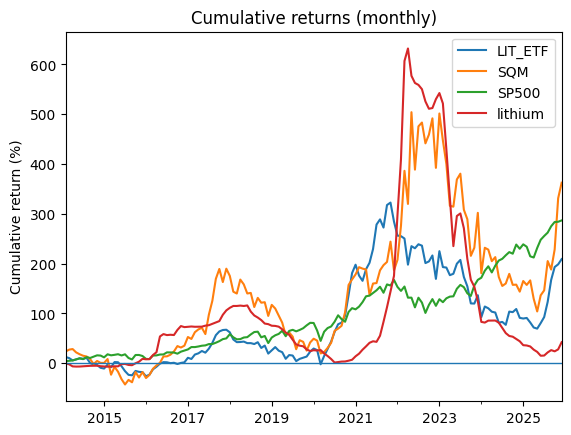

In [ ]:
#visual analysis


# returns acumulados en %
cumret = (1 + rets).cumprod() - 1

# plot
ax = (cumret * 100).plot()
plt.title("Cumulative returns (monthly)")
plt.ylabel("Cumulative return (%)")
plt.axhline(0, linewidth=1)
plt.show()

              SQM     SP500   LIT_ETF   lithium
SQM      1.000000  0.344956  0.654828  0.269599
SP500    0.344956  1.000000  0.610804 -0.031985
LIT_ETF  0.654828  0.610804  1.000000  0.084742
lithium  0.269599 -0.031985  0.084742  1.000000


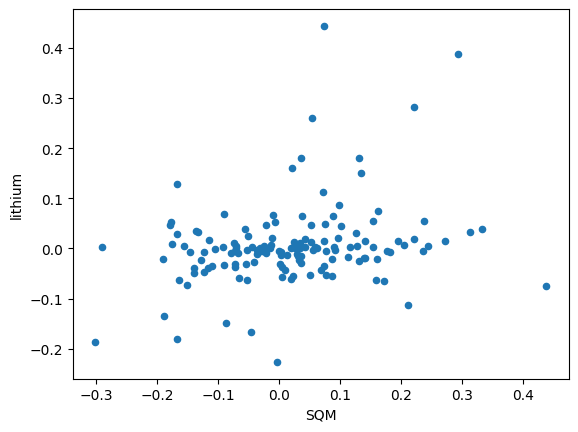

In [6]:
#now we do the correlation analysis
corr = rets[["SQM", "SP500", "LIT_ETF", "lithium"]].corr()

print(corr)

plot = rets[["SQM", "SP500", "LIT_ETF", "lithium"]].plot.scatter(x="SQM", y="lithium")


In [7]:
#what if the correlation between lithium and the stock holds with some lag of some months?
rets = df.pct_change().dropna()   
corr_lag2 = rets["SQM"].corr(rets["lithium"].shift(2))
print("Corr(SQM, lithium t-2) =", corr_lag2)

Corr(SQM, lithium t-2) = 0.12669152807008544


In [8]:
#Beta estimation with model capm (a+Bmkt+e)
x = sm.add_constant(rets["SP500"])
y = rets["SQM"]

capm = sm.OLS(y, x).fit()
beta = capm.params["SP500"]
alpha = capm.params["const"]

print(capm.summary())
print("beta =", beta, "alpha =", alpha)


                            OLS Regression Results                            
Dep. Variable:                    SQM   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     19.04
Date:                Fri, 20 Feb 2026   Prob (F-statistic):           2.45e-05
Time:                        19:26:54   Log-Likelihood:                 102.94
No. Observations:                 143   AIC:                            -201.9
Df Residuals:                     141   BIC:                            -195.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0077      0.010      0.751      0.4

In [ ]:
import numpy as np
import statsmodels.api as sm

# Asegúrate que df tenga columnas: SQM, LIT_ETF, lithium (y quizá SP500)
#data = df[["SQM", "LIT_ETF", "lithium"]].replace([np.inf, -np.inf], np.nan).dropna()

#y = data["SQM"]
#X_no_sp = sm.add_constant(data[["LIT_ETF", "lithium"]])

#model_no_sp = sm.OLS(y, X_no_sp).fit()

#print("R2:", model_no_sp.rsquared)
#print("Adj R2:", model_no_sp.rsquared_adj)
#print(model_no_sp.summary())


R2: 0.8575456095196954
Adj R2: 0.8555249798674924
                            OLS Regression Results                            
Dep. Variable:                    SQM   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     424.4
Date:                Fri, 20 Feb 2026   Prob (F-statistic):           2.16e-60
Time:                        19:26:54   Log-Likelihood:                -495.14
No. Observations:                 144   AIC:                             996.3
Df Residuals:                     141   BIC:                             1005.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co